In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [128]:
path = '/Users/yuqianxie/Desktop/DS_proj_analysis/dataset'
os.chdir(path)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/yuqianxie/Desktop/DS_proj_analysis/dataset


### Data Preprocessing

In [129]:
data = pd.read_excel('Merged_Sorted_Data_Herd_Daily.xlsx')
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sort data by 'Date'
data = data.sort_values('Date')
# Select the 'Date' and 'Total Amount of Milk Produced' columns
sub_data = data.iloc[:, [1, 17]]
sub_data = sub_data.dropna()
print(sub_data.head())

        Date  Total Amount of Milk Produced
0 2016-04-29                         4105.6
1 2016-04-30                         3952.1
2 2016-05-01                         3534.7
3 2016-05-02                         3584.9
4 2016-05-03                         4087.3


### Exploratory Data Analysis (EDA)
1. Plot the time series to visualize the trend
2. Decompose the times series to examine trend, seasonality, and residuals
3. Perform the ADF test to check for stationarity

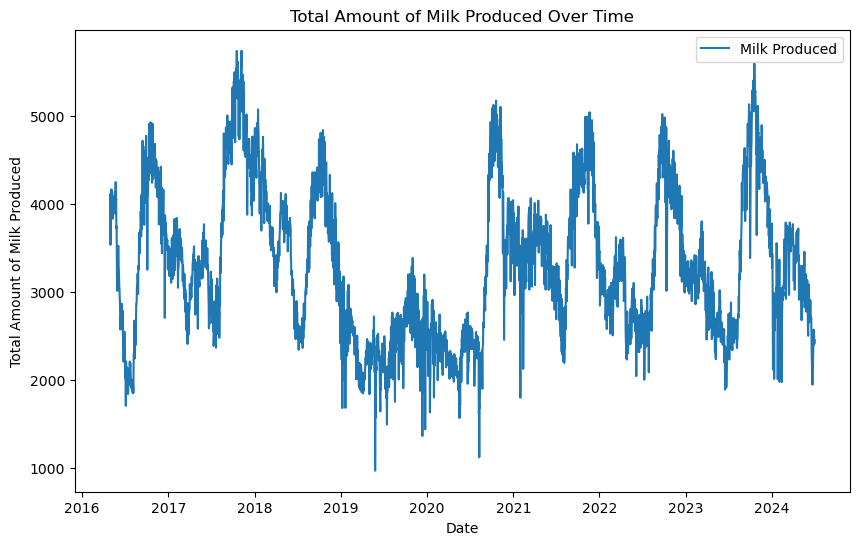

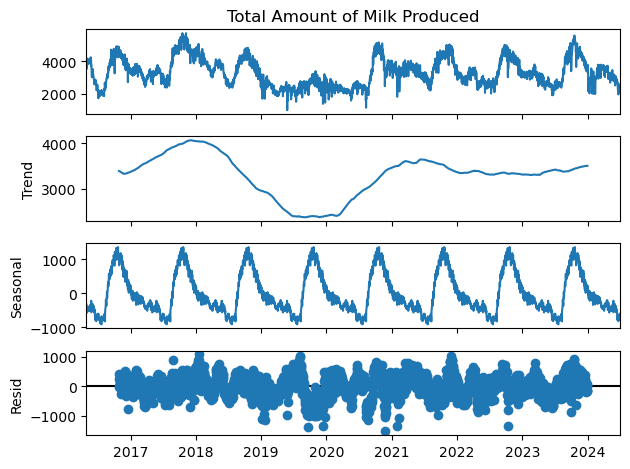

ADF Statistic: -4.884432067300089
p-value: 3.739116116892454e-05
Critical Values: {'1%': -3.432564886510389, '5%': -2.862518591340487, '10%': -2.567290930826469}
The time series is stationary


In [130]:
sub_data.set_index('Date', inplace=True)
# Plotting the time series to check for trend
plt.figure(figsize=(10, 6))
plt.plot(sub_data.index, sub_data['Total Amount of Milk Produced'], label='Milk Produced')
plt.title('Total Amount of Milk Produced Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount of Milk Produced')
plt.legend()
plt.show()

# Decomposing the time series to check for trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(sub_data['Total Amount of Milk Produced'], model='additive', period=365)
decomposition.plot()
plt.show()

# ADF test to check for stationary
result = adfuller(sub_data['Total Amount of Milk Produced'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

### Short Summary
Based on the exploratory data analysis (EDA) of the "Total Amount of Milk Produced" time series data:

1. **Trend Analysis**: The time series plot shows a clear cyclical pattern in milk production, with noticeable peaks and troughs over the years. There seems to be no strong upward or downward trend over the entire period, though there are periodic fluctuations.

2. **Seasonality**: The seasonal decomposition indicates a repeating seasonal pattern, which suggests the presence of seasonal factors influencing milk production. This is evident in the seasonal component plot, where similar patterns recur annually.

3. **Stationarity**: The Augmented Dickey-Fuller (ADF) test gives a p-value of approximately **0.000037**, which is well below the significance level of 0.05. This means the null hypothesis of non-stationarity is rejected, and the series can be considered **stationary**.

In conclusion, the data exhibits both cyclical and seasonal patterns, and the series is stationary, which makes it suitable for further time series modeling like ARIMA.

### Identifying the AR and MA orders

<Figure size 1000x600 with 0 Axes>

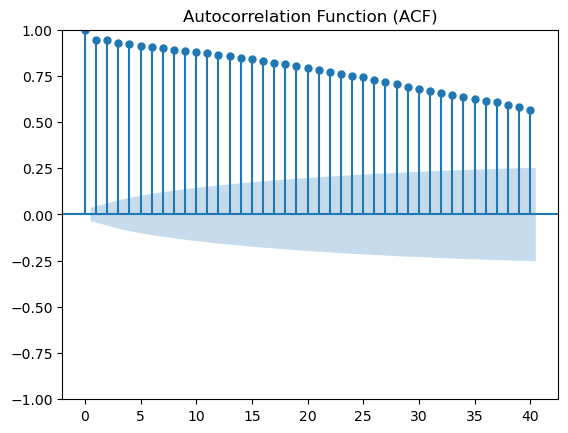

<Figure size 1000x600 with 0 Axes>

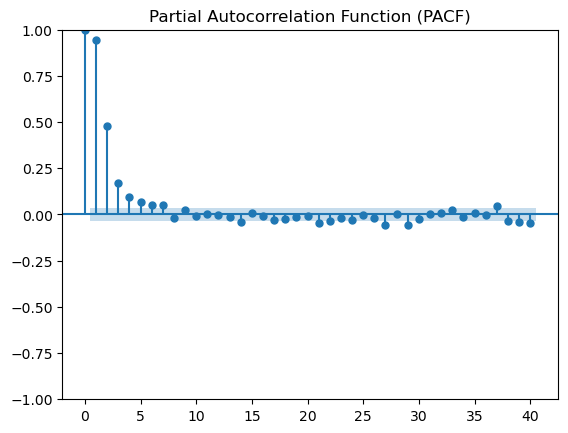

In [48]:
# Plot ACF (Auto-Correlation Function)
plt.figure(figsize=(10, 6))
plot_acf(sub_data['Total Amount of Milk Produced'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (Partial Auto-Correlation Function)
plt.figure(figsize=(10, 6))
plot_pacf(sub_data['Total Amount of Milk Produced'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

These plots help to identify the appropriate AR (Auto-Regressive) and MA (Moving Average) terms. Look at significant lags in the ACF plot to determine the MA order, and use the PACF plot to determine the AR order.

The ACF shows a slow decay over time, which typically suggests the presence of a MA (Moving Average) component. The significant lags in ACF are generally identified as those spikes that are outside the confidence interval (shaded area).From the PACF plot:

The PACF shows a clear cutoff after lag 1, meaning the first spike is significant and the others drop off quickly. This suggests the presence of an AR (Auto-Regressive) component.

Summary of Orders:

MA order (q): 1 or 2 (based on the ACF plot).

AR order (p): 1 (based on the PACF plot).

We can fit ARIMA models using the orders of ARIMA(1,1,1) and ARIMA(1,1,2), comparing their AIC and BIC values to select the better model.


### Model Selection

In [131]:
sub_data.index = pd.date_range(start=sub_data.index[0], periods=len(sub_data), freq='D')
# Step 1: Fit ARIMA(1, 1, 1)
model_111 = ARIMA(sub_data['Total Amount of Milk Produced'], order=(1, 1, 1), freq='D')
result_111 = model_111.fit()

# Step 2: Fit ARIMA(1, 1, 2)
model_112 = ARIMA(sub_data['Total Amount of Milk Produced'], order=(1, 1, 2), freq='D')
result_112 = model_112.fit()

# Step 3: Print summaries and compare AIC/BIC
print("ARIMA(1, 1, 1) Summary:")
print(result_111.summary())
print("\nARIMA(1, 1, 1) AIC:", result_111.aic)
print("ARIMA(1, 1, 1) BIC:", result_111.bic)

print("\nARIMA(1, 1, 2) Summary:")
print(result_112.summary())
print("\nARIMA(1, 1, 2) AIC:", result_112.aic)
print("ARIMA(1, 1, 2) BIC:", result_112.bic)

# Step 4: Select the model with the lower AIC/BIC
if result_111.aic < result_112.aic:
    print("\nARIMA(1, 1, 1) is the better model based on AIC.")
else:
    print("\nARIMA(1, 1, 2) is the better model based on AIC.")

if result_111.bic < result_112.bic:
    print("ARIMA(1, 1, 1) is the better model based on BIC.")
else:
    print("ARIMA(1, 1, 2) is the better model based on BIC.")

ARIMA(1, 1, 1) Summary:
                                     SARIMAX Results                                     
Dep. Variable:     Total Amount of Milk Produced   No. Observations:                 2985
Model:                            ARIMA(1, 1, 1)   Log Likelihood              -20622.830
Date:                           Sun, 15 Sep 2024   AIC                          41251.660
Time:                                   03:05:51   BIC                          41269.663
Sample:                               04-29-2016   HQIC                         41258.137
                                    - 06-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1316      0.027     -4.914      0.000      -0.184      -0.079
ma.L1         -0.48

Since we are looking at a model that balances goodness of fit and model complexity, ARIMA(1,1,2) might offer a slightly better fit based on AIC.


### Full Analysis Code with ARIMA(1,1,2)

In [132]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# # Step 1: Load data and ensure 'Date' is in datetime format
# data = pd.read_excel('Merged_Sorted_Data_Herd_Daily.xlsx')
# # Convert 'Date' column to datetime and handle any parsing errors
# data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
# # Drop rows where the 'Date' conversion failed
# data = data.dropna(subset=['Date'])
# # Sort data by 'Date'
# data = data.sort_values('Date')
# # Select the 'Date' and 'Total Amount of Milk Produced' columns, ensuring no missing values
# sub_data = data.iloc[:, [1, 17]]  # Update column indices if needed
# sub_data = sub_data.dropna()
# # Set 'Date' as index and specify the frequency as daily
# sub_data.set_index('Date', inplace=True)
# sub_data = sub_data.asfreq('D')
# # Step 2: Fit the ARIMA(1, 1, 2) model
# model = ARIMA(sub_data['Total Amount of Milk Produced'], order=(1, 1, 2))
# result = model.fit()
# # Step 3: Forecasting for the next 8 years (2920 days)
# forecast_steps = 8 * 365
# forecast = result.forecast(steps=forecast_steps)
# # Generate the future dates starting from the day after the last date in the dataset
# last_date = sub_data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='D')[1:]
# # Step 4: Output the forecast into a DataFrame
# forecast_df = pd.DataFrame({
#     'Date': future_dates,
#     'Forecasted Milk Production': forecast
# })
# # Save the forecast to a CSV file
# forecast_df.to_csv('forecast_milk_production_8_years.csv', index=False)
# # Step 5: Plot the forecast
# plt.figure(figsize=(10, 6))
# plt.plot(future_dates, forecast, label='Forecast', color='red')
# plt.title('Milk Production Forecast with ARIMA(1, 1, 2) - Next 8 Years')
# plt.xlabel('Date')
# plt.ylabel('Total Amount of Milk Produced')
# plt.legend()
# plt.show()
# Step 6: Diagnostics - Check residuals and their ACF, PACF
# residuals = result.resid
# plt.figure(figsize=(10, 6))
# plt.plot(residuals)
# plt.title('Residuals of ARIMA(1, 1, 2) Model')
# plt.show()
# 
# # Plot ACF and PACF of residuals to check for any autocorrelation
# plot_acf(residuals, lags=50)
# plt.title('ACF of Residuals')
# plt.show()
# 
# plot_pacf(residuals, lags=50)
# plt.title('PACF of Residuals')
# plt.show()

The ARIMA(1,1,2) model did not perform well in this case, so I switched to a SARIMA model and commented out the ARIMA model code.

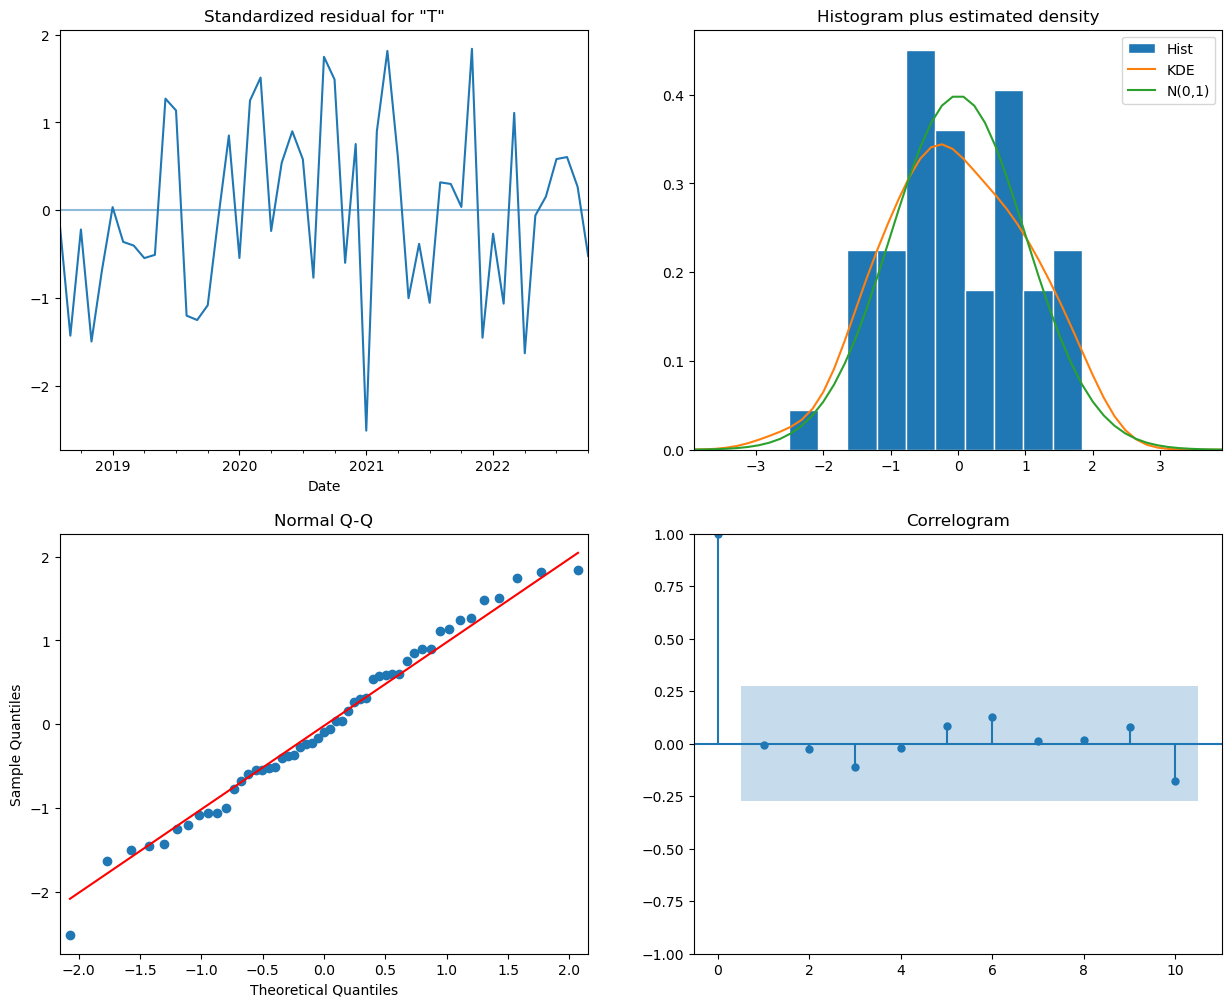

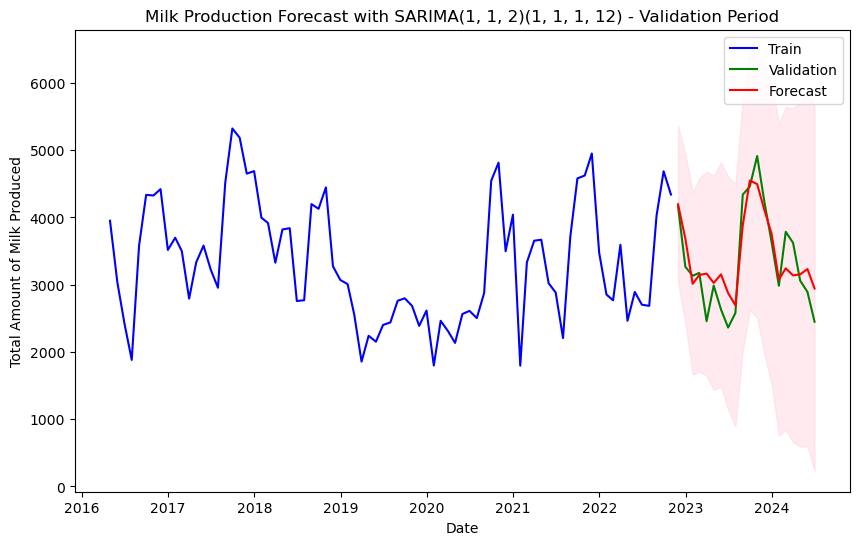

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
data = pd.read_excel('Merged_Sorted_Data_Herd_Daily.xlsx')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values('Date')
sub_data = data.iloc[:, [1, 17]]  
sub_data = sub_data.dropna()
# Set 'Date' as index and specify the frequency as monthly
sub_data.set_index('Date', inplace=True)
sub_data = sub_data.asfreq('M')
# Interpolating missing values
sub_data['Total Amount of Milk Produced'] = sub_data['Total Amount of Milk Produced'].interpolate()
# Splitting the data into train and validation sets
train_end = int(len(sub_data) * 0.8)
train_data = sub_data.iloc[:train_end]
validation_data = sub_data.iloc[train_end:]
# Fit the SARIMA model on the training dataset
sarima_model = SARIMAX(train_data['Total Amount of Milk Produced'],
                       order=(1, 1, 2),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
# Diagnostic checks
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()
# Forecasting for the next steps into the validation dataset
forecast_steps = len(validation_data)  # Forecast into the validation period
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = validation_data.index
# Output the forecast into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Milk Production': forecast.predicted_mean,
    'Confidence Interval Lower': forecast.conf_int().iloc[:, 0],
    'Confidence Interval Upper': forecast.conf_int().iloc[:, 1]
})
# Save the forecast to a CSV file
forecast_df.to_csv('forecast_milk_production_validation_period.csv', index=False)
# Plot the forecast alongside the observed data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Total Amount of Milk Produced'], label='Train', color='blue')
plt.plot(validation_data.index, validation_data['Total Amount of Milk Produced'], label='Validation', color='green')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Milk Production Forecast with SARIMA(1, 1, 2)(1, 1, 1, 12) - Validation Period')
plt.xlabel('Date')
plt.ylabel('Total Amount of Milk Produced')
plt.legend()
plt.show()

In [110]:
from sklearn.metrics import mean_squared_error
# Compute MSE for the validation period
actual_values = validation_data['Total Amount of Milk Produced']
predicted_values = forecast_df['Forecasted Milk Production']

mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error for the validation period: {mse}')

Mean Squared Error for the validation period: 128709.63412128281


In [136]:
from sklearn.metrics import mean_squared_error
# Model configurations to test
model_configs = [
    {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 12)},
    {'order': (1, 0, 2), 'seasonal_order': (1, 1, 1, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)},
    {'order': (1, 0, 1), 'seasonal_order': (1, 1, 1, 12)}
]
# Dictionary to store MSE for each configuration
mse_results = {}
min_mse = float('inf')
best_model = ""
# Fit and forecast for each configuration
for config in model_configs:
    sarima_model = SARIMAX(train_data['Total Amount of Milk Produced'],
                           order=config['order'],
                           seasonal_order=config['seasonal_order'],
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    result = sarima_model.fit(disp=False)

    # Forecasting for validation period
    forecast_steps = len(validation_data)
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_index = validation_data.index

    # Compute MSE
    actual_values = validation_data['Total Amount of Milk Produced']
    predicted_values = forecast.predicted_mean
    mse = mean_squared_error(actual_values, predicted_values)

    # Store MSE in dictionary
    mse_results[f"Order {config['order']} Seasonal Order {config['seasonal_order']}"] = mse

    # Track the best model
    if mse < min_mse:
        min_mse = mse
        best_model = f"Order {config['order']} Seasonal Order {config['seasonal_order']}"

# Print MSE for each configuration
for model, error in mse_results.items():
    print(f'{model}: MSE = {error}')

# Print the best model configuration
print(f'\nThe model with the smallest MSE is {best_model} with an MSE of {min_mse}')

Order (1, 1, 2) Seasonal Order (1, 1, 1, 12): MSE = 1285928.6905521757
Order (1, 0, 2) Seasonal Order (1, 1, 1, 12): MSE = 1263211.2862000419
Order (1, 1, 1) Seasonal Order (1, 1, 1, 12): MSE = 1287566.6528531394
Order (1, 0, 1) Seasonal Order (1, 1, 1, 12): MSE = 1265667.5180877727

The model with the smallest MSE is Order (1, 0, 2) Seasonal Order (1, 1, 1, 12) with an MSE of 1263211.2862000419


We can see that our forecasting is not bad comparing to our validation set, so that we can use SARIMA model to forcast our next 8 years milk production, next step is that we should decide which model is better, we have four models.

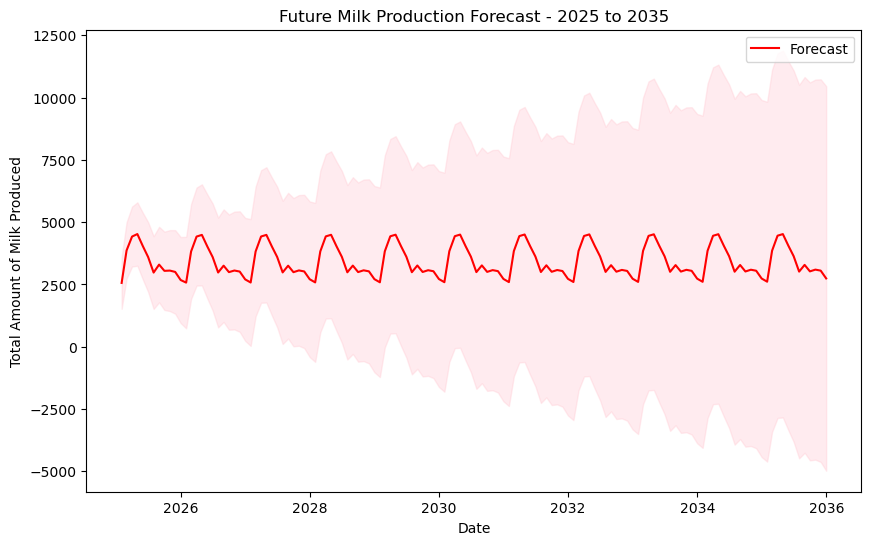

CSV file saves successfully.


In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sub_data = sub_data.asfreq('M')
# Interpolating missing values
sub_data['Total Amount of Milk Produced'] = sub_data['Total Amount of Milk Produced'].interpolate()
# Use all available data for training as it seems you want a pure forecast
train_data = sub_data
# Fit the SARIMA model
sarima_model = SARIMAX(train_data['Total Amount of Milk Produced'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)
# Determine the start date for forecasting
start_date = pd.Timestamp('2025-01-01')
forecast_start = max(start_date, train_data.index[-1] + pd.DateOffset(months=1))
# Forecasting from 2025 to 2035
forecast_end_year = 2035
forecast_steps = ((forecast_end_year - forecast_start.year + 1) * 12) - (forecast_start.month - 1)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='M')
# Get forecast
forecast = sarima_result.get_forecast(steps=forecast_steps)
# Output the forecast into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Milk Production': forecast.predicted_mean,
    'Confidence Interval Lower': forecast.conf_int().iloc[:, 0],
    'Confidence Interval Upper': forecast.conf_int().iloc[:, 1]
})
# Save the forecast to a CSV file
forecast_df.to_csv('forecast_SARIMA_2025_2035.csv', index=False)
# Plot the forecast to visualize
plt.figure(figsize=(10, 6))
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Future Milk Production Forecast - 2025 to 2035')
plt.xlabel('Date')
plt.ylabel('Total Amount of Milk Produced')
plt.legend()
plt.show()
# Print a completion message
print("CSV file saves successfully.")